In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Recuperar el mismo DataFrame
with open('dfe_guardado.pkl', 'rb') as e:
    dfe = pickle.load(e)
dfa = dfe.copy()

In [3]:
dfa.head(3000)

,torneo,semestre,ronda,fecha_torneo,equipo_local,equipo_visitante,goles_local,goles_visitante,resultado
0,2021,1,INICIAL,1,millonarios,envigado,1,0,LOCAL
1,2021,1,INICIAL,1,junior,medellin,1,0,LOCAL
2,2021,1,INICIAL,1,pasto,equidad,2,2,EMPATE
3,2021,1,INICIAL,1,nacional,santa fe,2,0,LOCAL
4,2021,1,INICIAL,1,cali,jaguares,1,0,LOCAL
...,...,...,...,...,...,...,...,...,...
2188,2025,2,CUADRANGULARES,1,medellin,america,1,1,EMPATE
2189,2025,2,CUADRANGULARES,1,fortaleza,santa fe,1,2,VISITANTE
2190,2025,2,CUADRANGULARES,1,bucaramanga,tolima,0,0,EMPATE
2191,2025,2,CUADRANGULARES,1,nacional,medellin,2,1,LOCAL


In [4]:
dfa = dfa.drop(['goles_local', 'goles_visitante'], axis=1)

In [5]:
dfa.dtypes

torneo               int64
semestre             int64
ronda               object
fecha_torneo         int64
equipo_local        object
equipo_visitante    object
resultado           object
dtype: object

In [6]:
# Separar características y variable objetivo
X = dfa.drop('resultado', axis=1)
y = dfa['resultado']

# Identificar columnas categóricas y numéricas
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [7]:
# Crear transformador: OneHotEncoder solo para categóricas

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

In [8]:
# Crear un Pipeline: preprocessing + modelo
pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight="balanced",
        min_samples_split=5,
        random_state=42
    ))
])

In [9]:
# VALIDACIÓN CRUZADA (evaluar estabilidad del modelo)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy')

print("\n===== VALIDACIÓN CRUZADA K-Fold =====")
print("Scores por fold:", scores)
print("Promedio:", scores.mean())
print("Desviación estándar:", scores.std())


===== VALIDACIÓN CRUZADA K-Fold =====
Scores por fold: [0.40546697 0.40318907 0.39635535 0.42922374 0.41552511]
Promedio: 0.40995204959382575
Desviación estándar: 0.011429622068586475


In [10]:
# Split 70–30 para entrenamiento final

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# Evaluación final
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\n===== RESULTADOS 70-30 =====")
print(f"Exactitud del modelo: {accuracy:.2f}")
print("\nMatriz de confusión:")
print(conf_matrix)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))



===== RESULTADOS 70-30 =====
Exactitud del modelo: 0.42

Matriz de confusión:
[[ 56  68  46]
 [ 68 129  59]
 [ 41  37  45]]

Reporte de clasificación:
              precision    recall  f1-score   support

      EMPATE       0.34      0.33      0.33       170
       LOCAL       0.55      0.50      0.53       256
   VISITANTE       0.30      0.37      0.33       123

    accuracy                           0.42       549
   macro avg       0.40      0.40      0.40       549
weighted avg       0.43      0.42      0.42       549



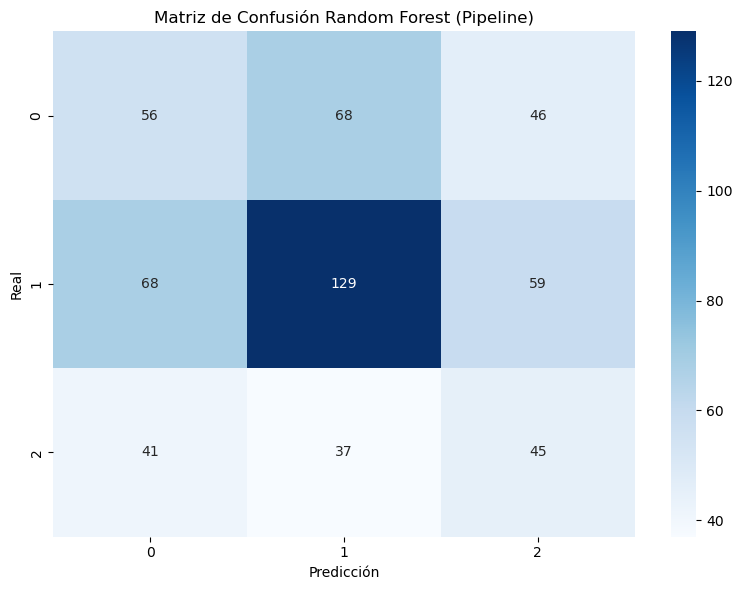

In [11]:
# Visualización de matriz de confusión

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Random Forest (Pipeline)')
plt.tight_layout()
plt.show()


===== PREDICCIÓN NUEVO PARTIDO =====
Predicción final: LOCAL

Probabilidades por clase:
EMPATE: 31.90%
LOCAL: 37.81%
VISITANTE: 30.29%


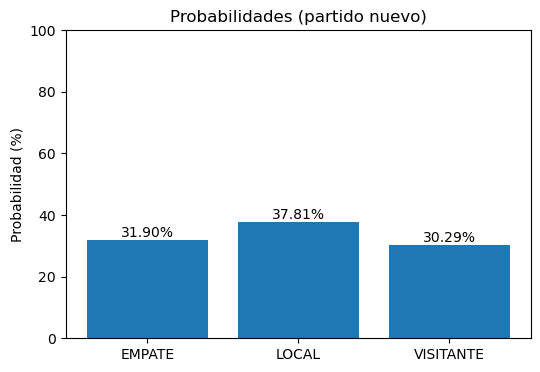

In [14]:
# Predicción de un nuevo partido

nuevo_partido = pd.DataFrame({
    'torneo': [2025],
    'semestre': [2],
    'ronda': ['INICIAL'],
    'fecha_torneo': [1],
    'equipo_local': ['tolima'],
    'equipo_visitante': ['junior']
})

# Asegurar que tiene las mismas columnas que X
nuevo_partido = nuevo_partido[X.columns]

prediccion = pipeline.predict(nuevo_partido)
proba = pipeline.predict_proba(nuevo_partido)

print("\n===== PREDICCIÓN NUEVO PARTIDO =====")
print(f"Predicción final: {prediccion[0]}")
print("\nProbabilidades por clase:")

clases = pipeline.named_steps['model'].classes_
for i, c in enumerate(clases):
    print(f"{c}: {proba[0][i]*100:.2f}%")

# Gráfico de probabilidades
plt.figure(figsize=(6,4))
plt.bar(clases, proba[0]*100)
plt.title("Probabilidades (partido nuevo)")
plt.ylabel("Probabilidad (%)")
plt.ylim(0,100)
for i, p in enumerate(proba[0]*100):
    plt.text(i, p+1, f"{p:.2f}%", ha='center')
plt.show()


In [15]:
y.value_counts()
y.value_counts(normalize=True)*100

resultado
LOCAL        45.782034
EMPATE       29.958960
VISITANTE    24.259006
Name: proportion, dtype: float64

##### 